# Even more NYC rent exploration

In the last notebook, we got a bunch of experience with the basic exploratory analysis tools and did some plotting.  There's a lot more we can learn from the data set, so let's jump in!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'   # svg vs png format make sharper images!

In [2]:
df_rent = pd.read_json('data/train.json')

## Cleaning up

Let's go through and clean up the data set to remove obviously incorrect or inappropriate or missing data.

<img src="images/redbang.png" width="30" align="left">We view all data cleaning operations through the lens of what exactly we want a predictive model to do or what our business use-case is. In our case, care about apartment rent prices and just for New York City and just for the reasonably priced apartments.

We saw in the previous notebook that some of the price values are sale price not rent price so let's start by stripping those out.  Instead of altering the original data frame, let's create a working data frame just called `df`:

In [3]:
df = df_rent[df_rent['price']<=10_000].copy()

 We use a copy so that we avoid errors when we alter this slice of the original `df_rent` data frame.
 
We also discovered a typo, an apartment that had 10 bathrooms; since they really meant 1, let's fix that too using the `loc` operation that specifies which row and column:

In [4]:
df.loc[df['bathrooms']==10, 'bathrooms'] = 1

### Restricting data to apartments in New York City

One of our goals is to restrict apartments to just New York City, so let's analyze the data and see what we can learn. [GPS coordinates](https://whatis.techtarget.com/definition/GPS-coordinates) are weird, but they represent degrees difference from "prime Meridian" (Greenwich England). Longitude lines are vertical and indicate +90 to -90 degrees from the prime Meridian. Latitude is zero at the equator and +90 and -90 at the north and south poles.  For example, if we type `40.7530, -73.9982` into Google maps, we get a location on the west side of Manhattan:

<img src="images/nyc.png" width="200">

Cool, so that gives us a general idea of the coordinates of New York City. Note the differences between GPS numbers will be very small.

From [a machine learning book I'm working on](https://mlbook.explained.ai/prep.html): A few apartments have GPS coordinates that put them in Boston, not New York City (for example, latitude, longitude of 40.5813, -74.5343). These coordinates could be typos or just erroneous lookups done by apartment managers. By scrutinizing the records, we could probably figure out whether it's a typo, but there are so few, we can just delete them. New York City does not fit neatly in a square, but we can still decide on a bounding box around it and then delete records outside of that box. A quick check at [gps-coordinates.org](https://gps-coordinates.org/new-york-city-latitude.php), gives a rough outline for New York City of latitude, longitude 40.55, -74.1 on the lower left and 40.94, -73.67 on the upper right. 

Let's revisit querying with dataframes.  If we test a column with a relational operator, the results is a column of Boolean values:

In [5]:
df['latitude']>40.55

4         True
6         True
9         True
10        True
15        True
          ... 
124000    True
124002    True
124004    True
124008    True
124009    True
Name: latitude, Length: 48474, dtype: bool

We can use that column of Boolean values as an index into a data frame. If a value is true, the associated row will appear in the resulting data frame:

In [6]:
bigger = df['latitude']>40.55
df[bigger].head(2).T

,4,6
bathrooms,1,1
bedrooms,1,2
building_id,8579a0b0d54db803821a35a4a615e97a,b8e75fc949a6cd8225b455648a951712
created,2016-06-16 05:55:27,2016-06-01 05:44:33
description,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...
display_address,145 Borinquen Place,East 44th
features,"[Dining Room, Pre-War, Laundry in Building, Di...","[Doorman, Elevator, Laundry in Building, Dishw..."
latitude,40.7108,40.7513
listing_id,7170325,7092344
longitude,-73.9539,-73.9722


Or, we can combine it with single expression:

In [7]:
df[ df['latitude']>40.55 ].head(2)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low


The problem is that we need to indicate the upper bound as well: `df['latitude']<40.94`. How do we combine the lower and upper bounds, and select only those rows? We combined with the `&` (and) operator. And, due to a quirk in the precedence of `&`, we have to put the individual sub expressions in parentheses:

In [8]:
df[(df['latitude']>40.55) & (df['latitude']<40.94)].head(2)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low


But, we also need to restrict the longitude to arrange. It looks complicated but it's really just a matter of and'ing together all of the limit operations. We can filter `df` for our full bounding box using::

In [9]:
df = df[(df['latitude']>40.55) &
        (df['latitude']<40.94) &
        (df['longitude']>-74.1) &
        (df['longitude']<-73.67)]
print(len(df), len(df_rent))

48417 49352


Stripping these records is “legal” because they don't fit within the goal previously established for the model. We are not arbitrarily deleting records.

In [10]:
df['latitude'].value_counts()

40.7530    299
40.7568    298
40.7301    245
40.7074    244
40.7073    236
          ... 
40.5958      1
40.8489      1
40.6511      1
40.8529      1
40.6846      1
Name: latitude, Length: 2305, dtype: int64

In [11]:
df['longitude'].value_counts()

-73.9982    292
-73.9875    268
-73.9864    266
-73.9838    247
-74.0149    238
           ... 
-73.8193      1
-74.0604      1
-73.7509      1
-74.0816      1
-74.0344      1
Name: longitude, Length: 1643, dtype: int64

In [12]:
df_nyc = df_rent[(df_rent['latitude']>40.55) &
                 (df_rent['latitude']<40.94) &
                 (df_rent['longitude']>-74.1) &
                 (df_rent['longitude']<-73.67)]
print(len(df_nyc), len(df_rent))

49290 49352


### Heat map from GPS coordinates

Once we have filtered the GPS coordinates to a reasonable bounding box around New York City, we can try to plot a dot for every apartment.

In [13]:
%config InlineBackend.figure_format = 'retina' # much faster than when generating lots of points

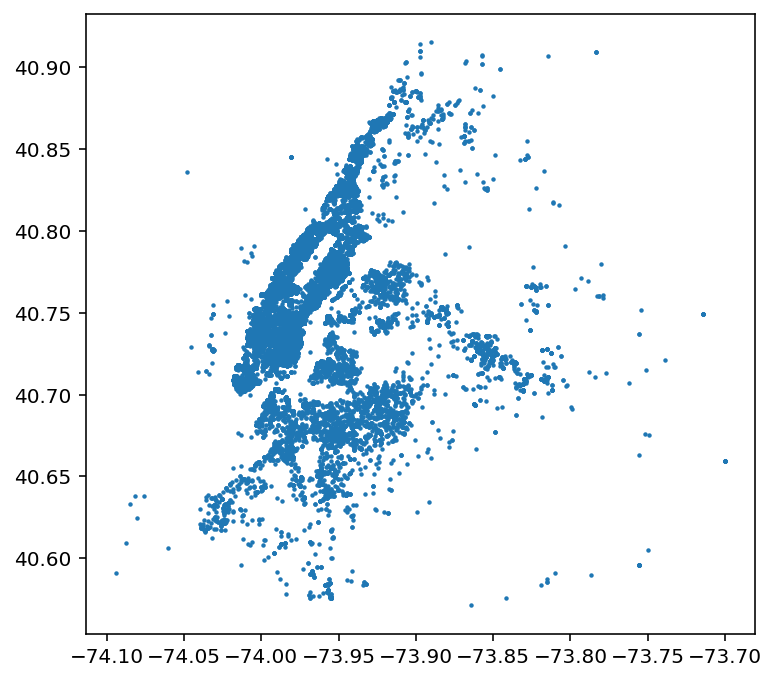

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5.7))

ax.scatter(df['longitude'], df['latitude'], s=1.5) # size = 1.5 per dot
plt.show()

If you are familiar with the outline of Manhattan, you can see it clearly marked.

We can do a better job than this visualizing the data, however. We can use color to indicate apartment price, mapping low to high as purple to red.  Because of the wide distribution of prices, I set red to be any apartment rent above 4000.

The key difference that makes this scatterplot a heat map is the `cmap` (color map) and `c` (color) parameters.

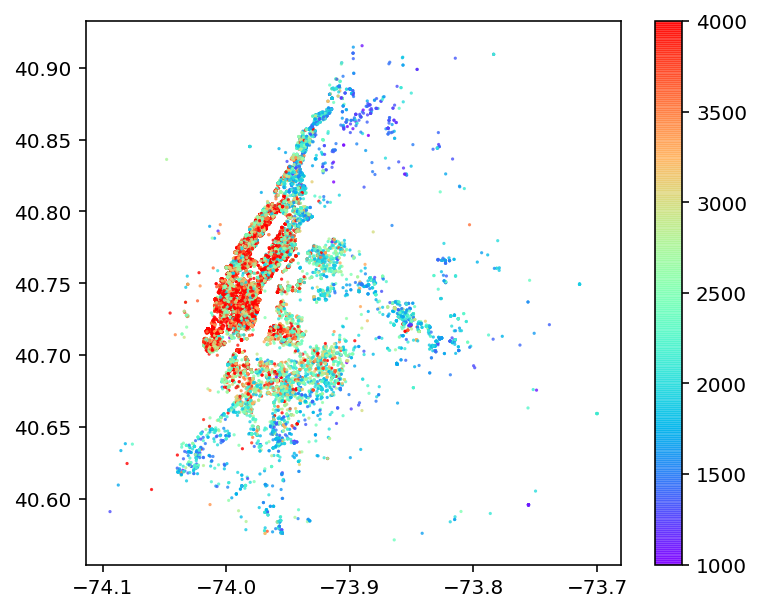

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
m = ax.scatter(df['longitude'],
               df['latitude'],
               alpha=0.8,
               s=1.5, # pixel size
               vmin=1000, vmax=4000, # limit price range so 4000 is red
               c=df['price'],
               cmap='rainbow', # color map
               marker='.')
plt.colorbar(m) # show a color bar on the right using data from the scatterplot
plt.show()

## Shattering dates

## Extracting elements from strings